In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import tifffile as tif
from os import listdir
from os.path import isfile, join
from pathlib import Path
from cellpose import io, models

In [2]:
BASE_PATH = "/bigdata/casus/MLID/Virtual_Staining_Nature_Final/HSV"

In [3]:
def read_tiff(path: str) -> np.ndarray:
    im_stack = tif.imread(path)
    if len(im_stack.shape) == 4:
        im_stack = im_stack[:, 0]

    return im_stack

def get_percentiles(x):
    mi = np.percentile(x, 3, axis=None)
    ma = np.percentile(x, 99.8, axis=None)
    return mi, ma

def read_data(channel):
    paths_w1 = list(Path(BASE_PATH).glob(f"**/*_w{str(channel)}.TIF"))
    n_sequences = len(paths_w1)
    data = []
    for idx in tqdm(range(n_sequences)):
        w1_path = str(paths_w1[idx])
        w1_ch = np.expand_dims(read_tiff(w1_path), -1) / 65535.0
        data.append(w1_ch)
    data = np.array(data, dtype=np.float32)
    return data

def hist(imgs):
    imgs = (imgs*255).astype(np.uint8)
    unique, counts = np.unique(imgs, return_counts=True)
    all_counts = np.zeros(np.max(unique)+1)
    all_counts[unique] = counts
    
    plt.figure(figsize=(12,12))
    plt.stairs(all_counts)
    plt.yscale('log')
    plt.xlim(0, np.max(unique)+1)

In [12]:
data = read_data(1)
get_percentiles(data)

100%|██████████| 960/960 [00:53<00:00, 18.07it/s]


(0.007415884640067816, 0.29068437218666077)

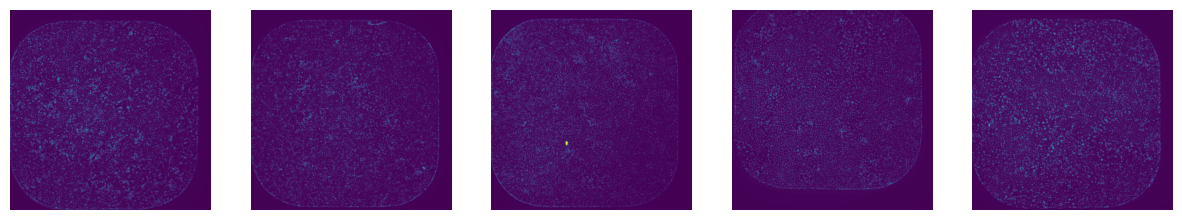

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(data[i])
    axes[i].axis('off')  

plt.show()

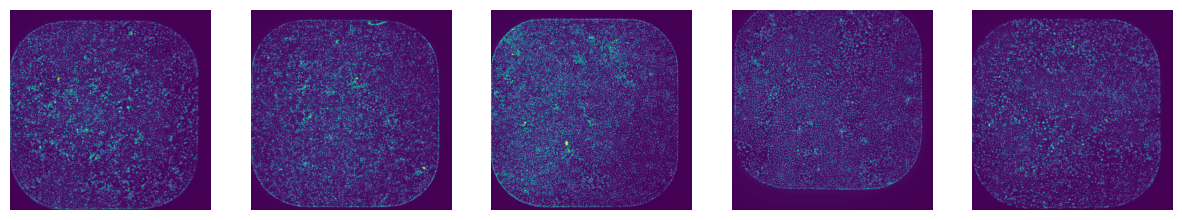

In [15]:
min_p=0.0074
max_p=0.2907

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    d = (data[i] - min_p) / (max_p - min_p)
    d = np.clip(d, 0, 1)
    axes[i].imshow(d)
    axes[i].axis('off')  

plt.show()

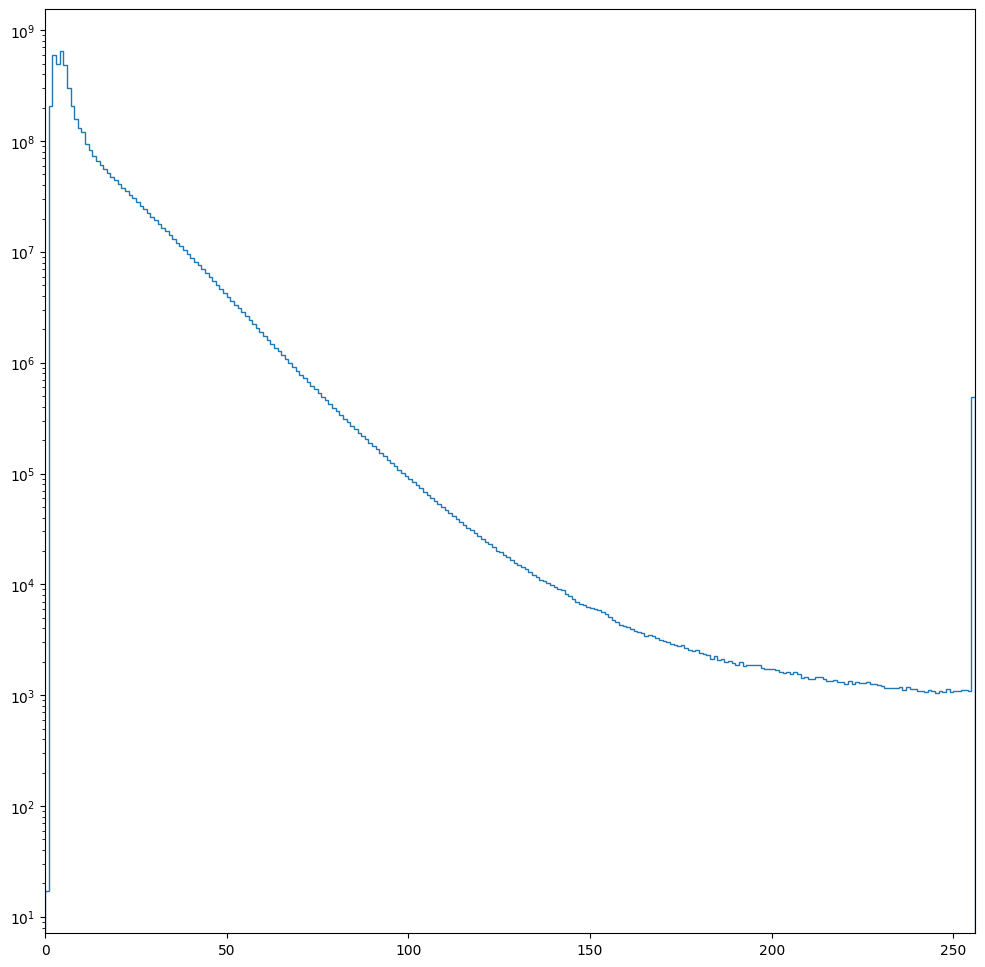

In [16]:
hist(data)

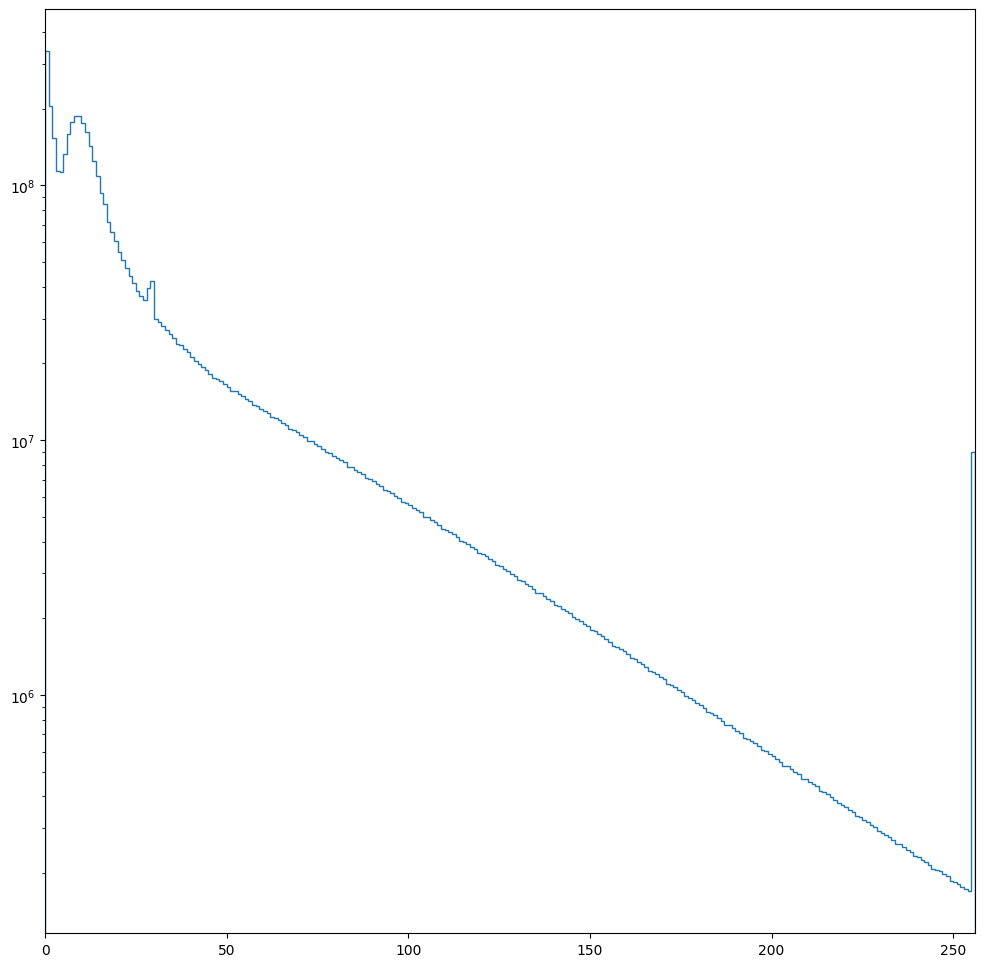

In [17]:
data_norm = (data - min_p) / (max_p - min_p)
data_norm = np.clip(data_norm, 0, 1)
hist(data_norm)

In [4]:
data = read_data(2)
get_percentiles(data)

100%|██████████| 960/960 [00:42<00:00, 22.71it/s]


(0.003311207750812173, 0.1925993710756302)

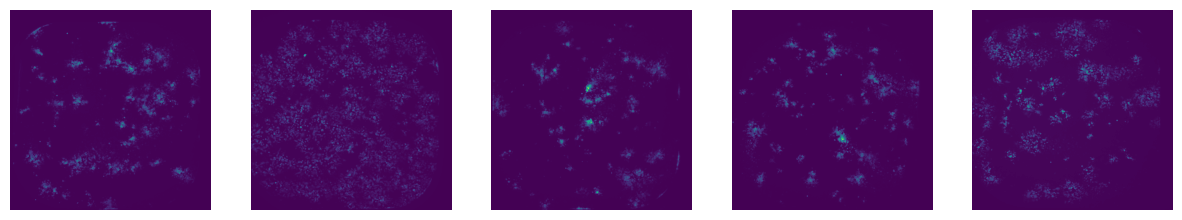

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(data[i])
    axes[i].axis('off')  

plt.show()

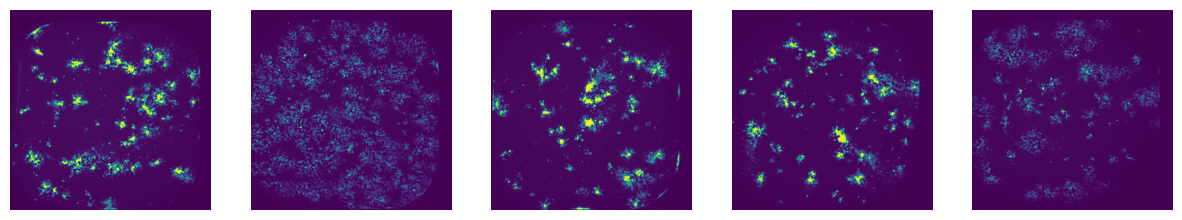

In [8]:
min_p=0.0033
max_p=0.1926

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    d = (data[i] - min_p) / (max_p - min_p)
    d = np.clip(d, 0, 1)
    axes[i].imshow(d)
    axes[i].axis('off')  

plt.show()

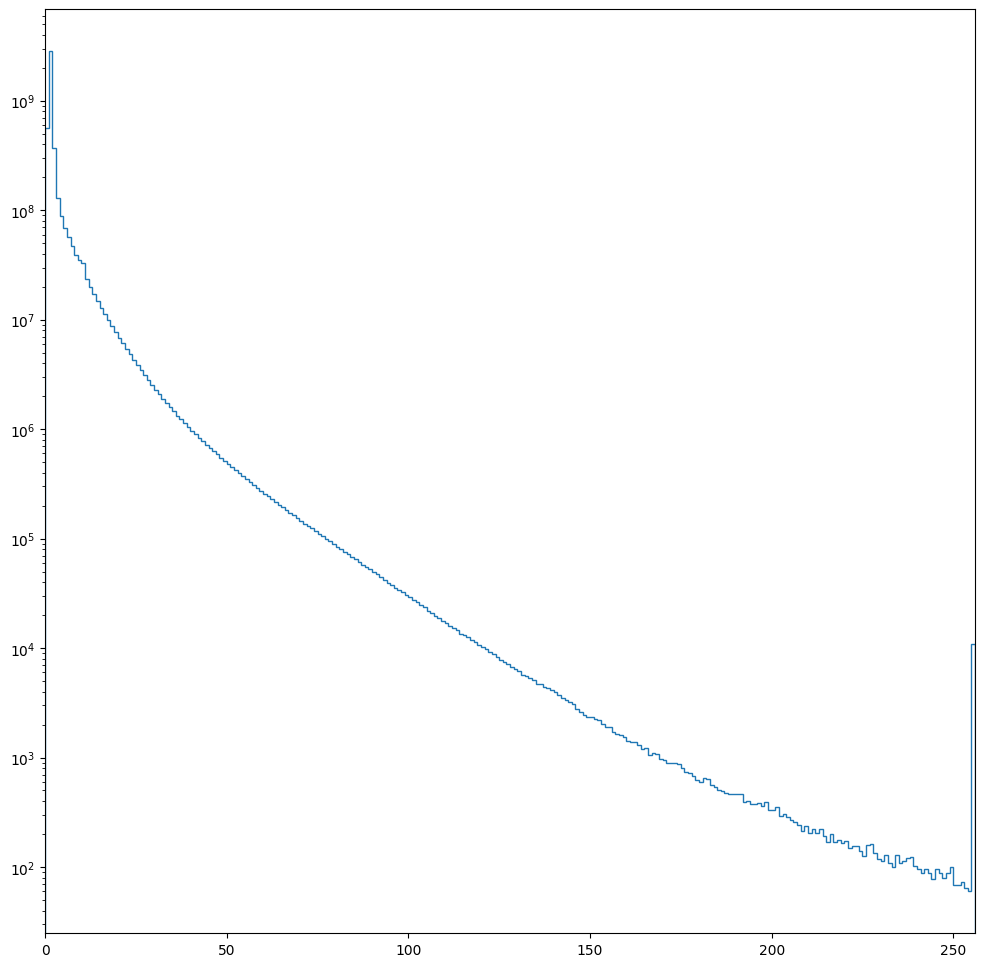

In [9]:
hist(data)

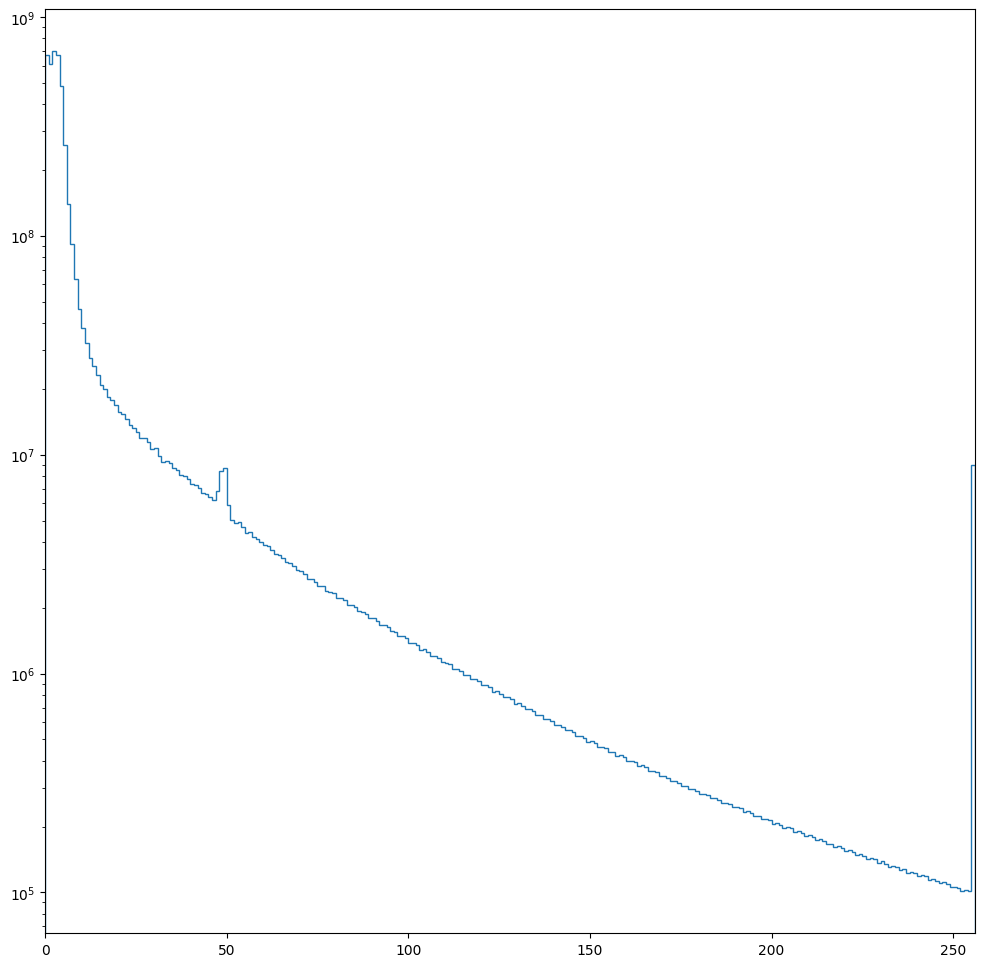

In [10]:
data_norm = (data - min_p) / (max_p - min_p)
data_norm = np.clip(data_norm, 0, 1)
hist(data_norm)

In [14]:
read_tiff("/bigdata/casus/MLID/maria/RV_normalized/processed_original_size/train/gt/170828-preZ-p9-HRV_A01.tif")

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]])

Saving data
(537,) (154,) (77,)


  0%|          | 0/537 [00:00<?, ?it/s]


ZeroDivisionError: division by zero

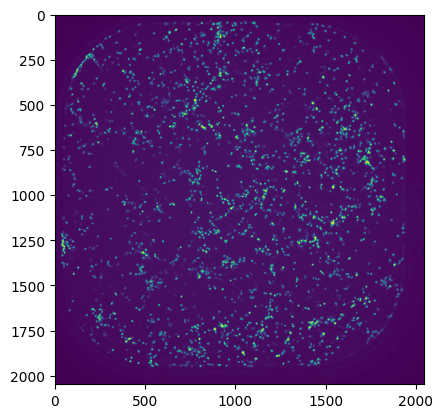

In [22]:
import os
from pathlib import Path

import cv2
import numpy as np
import tifffile as tif
from tqdm import tqdm

VAL_FRACTION = 0.2
TEST_FRACTION = 0.1

np.random.seed(42)

BASE_PATH = "/bigdata/casus/MLID/Virtual_Staining_Nature_Final/RV/raw"
OUTPUT_PATH = "/bigdata/casus/MLID/maria/RV_normalized"

HSV_percentiles = {
    "w1": {"min": 0.0074, "max": 0.2907},
    "w2": {"min": 0.0033, "max": 0.1926},
}
RV_percentiles = {
    "w1": {"min": 0.0086, "max": 0.2193},
    "w2": {"min": 0.0082, "max": 0.1712},
}
IAV_percentiles = {
    "w1": {"min": 0.011, "max": 0.2156},
    "w2": {"min": 0.0091, "max": 0.1769},
}

percentiles = RV_percentiles


def sample_norm(x, min, max):
    n_x = np.clip((x - min) / (max - min), 0, 1)
    return n_x * 2 - 1


paths = list(Path(BASE_PATH).glob(f"**/*_w1.TIF"))

paths = np.unique(np.array(paths))
indices = np.arange(len(paths))
np.random.shuffle(indices)
paths = paths[indices]

val_split_idx = int(len(paths) * (1 - VAL_FRACTION - TEST_FRACTION))
test_split_idx = int(len(paths) * (1 - TEST_FRACTION))

paths_train = paths[:val_split_idx]
paths_val = paths[val_split_idx:test_split_idx]
paths_test = paths[test_split_idx:]

print("Saving data")
print(paths_train.shape, paths_val.shape, paths_test.shape)

for split, paths in zip(["train", "val", "test"], [paths_train, paths_val, paths_test]):
    for path in tqdm(paths):
        for resize in [False]:

            w1_ch = np.expand_dims(tif.imread(path), -1)  / 65535.0

            w2_path = Path(str(path).replace("w1", "w2"))
            w2_ch = np.expand_dims(tif.imread(w2_path), -1)  / 65535.0

            if resize:
                w1_ch = sample_norm(
                    np.expand_dims(
                        cv2.resize(w1_ch, (256, 256), interpolation=cv2.INTER_LANCZOS4),
                        -1,
                    ),
                    min=percentiles["w1"]["min"],
                    max=percentiles["w1"]["max"],
                )
                w2_ch = sample_norm(
                    np.expand_dims(
                        cv2.resize(w2_ch, (256, 256), interpolation=cv2.INTER_LANCZOS4),
                        -1,
                    ),
                    min=percentiles["w2"]["min"],
                    max=percentiles["w2"]["max"],
                )
            else:
                w1_ch = sample_norm(
                    w1_ch,
                    min=percentiles["w1"]["min"],
                    max=percentiles["w1"]["max"],
                )
                w2_ch = sample_norm(
                    w2_ch,
                    min=percentiles["w2"]["min"],
                    max=percentiles["w2"]["max"],
                )
                plt.imshow(w2_ch)
                2/0